In [11]:
import sys
sys.path.append("../..")

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as ss

from transfernode import node
from transfernode import line
from stochastic import stochastic
from genetics import ga
import tools

In [2]:
avtovokzal = node.Node()
# start times counting from 5AM: [75, 90, 30, 95, 0]
# start times counting from 6:30AM: [20, 0, 0, 5, 14]
line1 = line.Line(75, 15 + 20, stochastic.Stochastic(1, 3, 0.5), 0.35, "#1")
line2 = line.Line(90, 30, stochastic.Stochastic(1, 4, 1), 0.20, "#2")
line3 = line.Line(30, 20, stochastic.Stochastic(1, 5, 1), 0.25, "#3")
line4 = line.Line(95, 28, stochastic.Stochastic(1, 4, 0.5), 0.10, "#4")
line5 = line.Line(0, 26, stochastic.Stochastic(1, 4, 0.5), 0.10, "#5")

avtovokzal.origin_pass_number = 12  # [pas./h]
avtovokzal.lines = [line1, line2, line3, line4, line5]

In [ ]:
nd, dur, N = avtovokzal, 180, 300

def fitness_function(shifts):
    for idx in range(len(nd.lines)):
        nd.lines[idx].shift = shifts[idx]
    res = []
    for _ in range(N):
        x = nd.simulate(duration=dur)
        res.append(x[0] / x[1])
    return np.array(res)

# res = fitness_function([20, 0, 0, 5, 14])
# res = fitness_function([75, 90, 30, 95, 0])

## Run GA

In [6]:
N = 100

winners = []
for pop_size in range(20, 220, 20):
    print(pop_size)
    g = ga.GA()
    g.chromosome_size = len(avtovokzal.lines), 7
    g.population_size = pop_size
    g.generations = 10
    g.crossover_probability = 0.5
    g.mutation_probability = 0.2
    g.mutation_turns = 3
    g.fitness_function = lambda xs: fitness_function(xs).mean()
    winner = g.run()
    winners.append(winner[1])
    print()

20
winner #1 ([51, 49, 10, 14, 65], (15.3833400837052, <genetics.chromosome.Chromosome object at 0x123662620>))
winner #2 ([35, 49, 10, 14, 27], (14.033533371149183, <genetics.chromosome.Chromosome object at 0x12343ab60>))
winner #3 ([35, 49, 10, 14, 27], (14.149186110392327, <genetics.chromosome.Chromosome object at 0x12343ab60>))
winner #4 ([35, 17, 10, 14, 27], (13.586447571588494, <genetics.chromosome.Chromosome object at 0x1236623b0>))
winner #5 ([33, 17, 10, 14, 27], (13.25534814114395, <genetics.chromosome.Chromosome object at 0x10734b310>))
winner #6 ([3, 17, 10, 14, 11], (12.994902013841608, <genetics.chromosome.Chromosome object at 0x123662890>))
winner #7 ([33, 17, 10, 15, 27], (12.859805324348837, <genetics.chromosome.Chromosome object at 0x123662b60>))
winner #8 ([19, 17, 10, 14, 11], (12.766757723849228, <genetics.chromosome.Chromosome object at 0x10734bcd0>))
winner #9 ([19, 17, 10, 14, 11], (12.76053510345488, <genetics.chromosome.Chromosome object at 0x10734b220>))
win

In [7]:
np.array(winners).tofile('node_results/node_SP_10x10.txt', sep=',', format='%s')

## Analyze results

In [9]:
xs = np.fromfile('node_results/node_SP_10x10.txt', sep=',').reshape((10, 10))

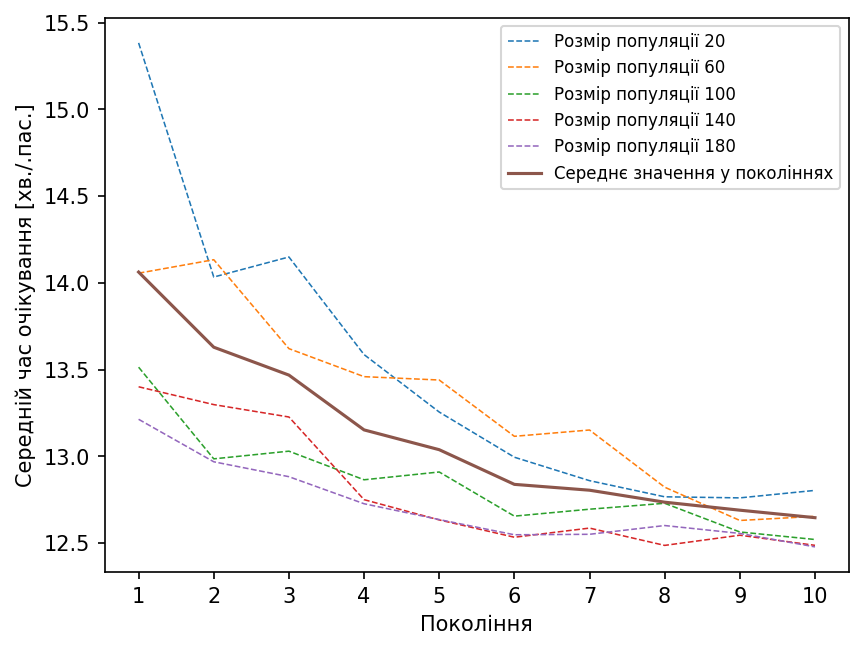

In [21]:
plt.figure(dpi=150)
idx = 0
for SP in range(20, 220, 40):
    plt.plot(range(1, 11), xs[idx*2],lw=0.75, label=f'Розмір популяції {SP}', linestyle='--')
    idx += 1
plt.plot(range(1, 11), xs.mean(axis=0), lw=1.5, label=f'Середнє значення у поколіннях')
plt.ylabel('Середній час очікування [хв./.пас.]')
plt.xlabel('Покоління')
plt.xticks(range(1, 11))
plt.legend(fontsize=8)
plt.show()

intercept=12.797898132296837
coefs=[-0.00150275]
R2=0.3589454262530327
t_alfa(0.01,8)=3.3553873313333957
coef1	True	-0.002605601232178369	-0.0003999064714378187
intercept=15.108960444659752
coefs=[-0.00944421]
R2=0.6378615511935928
t_alfa(0.001,8)=5.0413054333884535
coef1	True	-0.01531551834709103	-0.0035729103397587024
intercept=13.57627123526497
coefs=[-0.00427049]
R2=0.6708499152154634
t_alfa(0.001,8)=5.0413054333884535
coef1	True	-0.006738557719627105	-0.001802425414121631


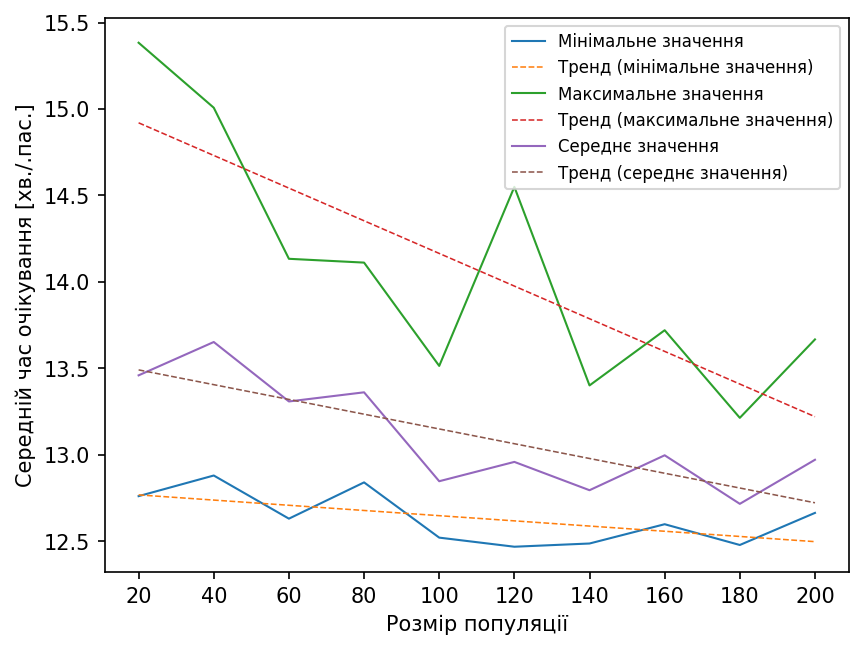

In [17]:
xticks = range(20, 220, 20)

X = np.array([[x for x in xticks]]).T
rm_min = tools.make_regression(X, xs.min(axis=1), alpha=0.01, verbose=True)[0]
rm_max = tools.make_regression(X, xs.max(axis=1), alpha=0.001, verbose=True)[0]
rm_mean = tools.make_regression(X, xs.mean(axis=1), alpha=0.001, verbose=True)[0]

linear = lambda a, b, x: a + b * x

plt.figure(dpi=150)

plt.plot(xticks, xs.min(axis=1), lw=1, label='Мінімальне значення', linestyle='-')
plt.plot(xticks, linear(rm_min.intercept_, rm_min.coef_, xticks), lw=0.75, label='Тренд (мінімальне значення)', linestyle='--')

plt.plot(xticks, xs.max(axis=1), lw=1, label='Максимальне значення', linestyle='-')
plt.plot(xticks, linear(rm_max.intercept_, rm_max.coef_, xticks), lw=0.75, label='Тренд (максимальне значення)', linestyle='--')

plt.plot(xticks, xs.mean(axis=1), lw=1, label='Середнє значення', linestyle='-')
plt.plot(xticks, linear(rm_mean.intercept_, rm_mean.coef_, xticks), lw=0.75, label='Тренд (середнє значення)', linestyle='--')

plt.ylabel('Середній час очікування [хв./.пас.]')
plt.xlabel('Розмір популяції')
plt.xticks(xticks)
plt.legend(fontsize=8)
plt.show()